<a href="https://colab.research.google.com/github/nitheesh-me/24_HourHackthon-Amrita/blob/master/project_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing packages

In [0]:
import csv
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data_samp_ROOMS_all_ver0 - Sheet1.csv to data_samp_ROOMS_all_ver0 - Sheet1.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data_samp_ROOMS_all_ver0 - Sheet1.csv']))
print(df[0:5])

  Start  End  Max.Capacity  Occupancy  Hazard  Fire Trigger
0   R11  S12             4          2       0             4
1   S12  R13             9          2       3            47
2   R13  R14             2          5       0            74
3   R14  R15             0          8       4            61
4   R15  S16             7          6       3            46


In [0]:
nodes = df.loc[np.where(df['Start'] == df['End'])]
edges = df.loc[np.where(df['Start'] != df['End'])]
exits = nodes.loc[nodes['Start'].str.contains("E")]
nodes = nodes.drop(list(exits.index.values))
safe_exit_concat = edges[['Start','End']]
safe_exit_graph =  safe_exit_concat.dropna()

In [5]:
print(exits[:5])

   Start End  Max.Capacity  Occupancy  Hazard  Fire Trigger
47    E6  E6     100000000          0       0     100000000
48    E0  E0     100000000          0       0     100000000


In [6]:
print(nodes[-5:])

   Start  End  Max.Capacity  Occupancy  Hazard  Fire Trigger
42   S41  S41             1          8       3            27
43   S51  S51             8          7       5            86
44   R52  R52             3         10       5            12
45   R53  R53             0          8       1            97
46   S54  S54             7          0       4            95


In [7]:
print(edges[-5:])

   Start  End  Max.Capacity  Occupancy  Hazard  Fire Trigger
22   S51  R52             5          6       2            61
23   R52  R53            10          6       2            58
24   R53  S54             1          5       2           100
25   S51   E6             2          6       5            83
26   S54   E6             2          9       5            90


In [8]:
print(safe_exit_graph[-5:])

   Start  End
22   S51  R52
23   R52  R53
24   R53  S54
25   S51   E6
26   S54   E6


In [9]:
floors ={}
min_floor = 100000
max_floor = -1
for index, row in nodes.iterrows():
  room = row["Start"]
  floor = room[1]
  min_floor = min(int(floor),min_floor)
  max_floor = max(int(floor),max_floor)
  if floor not in floors.keys():
    floors[floor] = []
  floors[floor].append(tuple(row[["Start","Occupancy","Hazard","Fire Trigger"]]))
from pprint import pprint
#pprint(floors)
for index, row in exits.iterrows():
  room = row["Start"]
  floor = room[1]
  if floor not in floors.keys():
    floors[floor] = []
  floors[floor].append(tuple(row[["Start","Occupancy","Hazard","Fire Trigger"]]))
pprint(floors)

{'0': [('E0', 0, 0, 100000000)],
 '1': [('R11', 5, 0, 32),
       ('S12', 8, 5, 49),
       ('R13', 10, 1, 82),
       ('R14', 9, 1, 88),
       ('R15', 1, 3, 67),
       ('S16', 1, 4, 64)],
 '2': [('S21', 0, 1, 43),
       ('R22', 7, 5, 54),
       ('R23', 1, 0, 13),
       ('S24', 9, 0, 2),
       ('R25', 4, 1, 17)],
 '3': [('S31', 2, 2, 83),
       ('R32', 4, 0, 42),
       ('R33', 7, 5, 55),
       ('S34', 3, 2, 18)],
 '4': [('S41', 8, 3, 27)],
 '5': [('S51', 7, 5, 86),
       ('R52', 10, 5, 12),
       ('R53', 8, 1, 97),
       ('S54', 0, 4, 95)],
 '6': [('E6', 0, 0, 100000000)]}


In [0]:
safe_exit_graph_dict = {k: g["End"].tolist() for k,g in edges.groupby("Start")}

In [29]:
pprint(safe_exit_graph_dict)

{'R11': ['S12'],
 'R13': ['R14'],
 'R14': ['R15'],
 'R15': ['S16'],
 'R22': ['R23'],
 'R23': ['S24'],
 'R32': ['R33'],
 'R33': ['S34'],
 'R52': ['R53'],
 'R53': ['S54'],
 'S12': ['R13', 'S21', 'E0'],
 'S16': ['S24', 'E0'],
 'S21': ['R22', 'S31'],
 'S24': ['R25', 'R32'],
 'S31': ['R32', 'S41'],
 'S34': ['S41'],
 'S41': ['S51', 'S54'],
 'S51': ['R52', 'E6'],
 'S54': ['E6']}


In [0]:
def _process_params(center, dim):
    # Some boilerplate code.
    import numpy as np
    if center is None:
        center = np.zeros(dim)
    else:
        center = np.asarray(center)

    if len(center) != dim:
        msg = "length of center coordinates must match dimension of layout"
        raise ValueError(msg)

    return center
def rescale_layout(pos, scale=1):
    lim = 0  # max coordinate for all axes
    for i in range(pos.shape[1]):
        pos[:, i] -= pos[:, i].mean()
        lim = max(abs(pos[:, i]).max(), lim)
    # rescale to (-scale, scale) in all directions, preserves aspect
    if lim > 0:
        for i in range(pos.shape[1]):
            pos[:, i] *= scale / lim
    return pos
def random_constrained_layout(scale=1, center=None, dim=2,floors=None,ab=[1,1], xy=[0,0]):
    
    import numpy as np
    rotate = np.pi / 3
    if dim < 2:
        raise ValueError('cannot handle dimensions < 2')
    exact_center = len(floors)//2
    out={}
    for i,(floor_lable,floor) in enumerate(sorted(floors.items())):

      center = _process_params(center, dim)

      paddims = max(0, (dim - 2))

      if len(floor) == 0:
          pos = {}
      elif len(floor) == 1:
        print(center)
        pos = {floor[0][0]: center+(np.array(xy)*i)}
      else:
          # Discard the extra angle since it matches 0 radians.
          theta = np.linspace(0, 1, len(floor) + 1)[:-1] * 2 * np.pi
          theta = theta.astype(np.float32)
          pos = np.column_stack([ab[0]*np.cos(theta+rotate)+(i*xy[0]), ab[1]*np.sin(theta+rotate)+(i*xy[1]),
                                 np.zeros((len(floor), paddims))])
          #pos = rescale_layout(pos, scale=scale) + center
          pos = {k[0]:p for index,(k,p) in enumerate(zip(floor,pos))}
          #print(pos)
      out.update(pos)
    return out

[0. 0.]
[0. 0.]
[0. 0.]
0 [('E0', 0, 0, 100000000)]
1 [('R11', 5, 0, 32), ('S12', 8, 5, 49), ('R13', 10, 1, 82), ('R14', 9, 1, 88), ('R15', 1, 3, 67), ('S16', 1, 4, 64)]
2 [('S21', 0, 1, 43), ('R22', 7, 5, 54), ('R23', 1, 0, 13), ('S24', 9, 0, 2), ('R25', 4, 1, 17)]
3 [('S31', 2, 2, 83), ('R32', 4, 0, 42), ('R33', 7, 5, 55), ('S34', 3, 2, 18)]
4 [('S41', 8, 3, 27)]
5 [('S51', 7, 5, 86), ('R52', 10, 5, 12), ('R53', 8, 1, 97), ('S54', 0, 4, 95)]
6 [('E6', 0, 0, 100000000)]


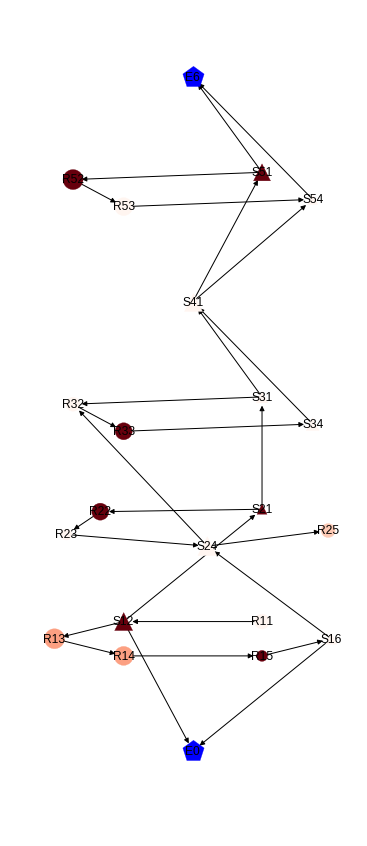

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 15]


#custom images
#from PIL import Image
#import requests
#from io import BytesIO
#url = "https://img.icons8.com/color/48/000000/filled-like.png"
#response = requests.get(url)
#img = Image.open(BytesIO(response.content))

#preprocessing

graph = nx.DiGraph(safe_exit_graph_dict)

pos=random_constrained_layout(graph, floors=floors, ab=[1,0.3], xy=[0.0,1.7])
#nx.draw(graph,pos=pos ,with_labels=True)
for i,(l,room) in enumerate(sorted(floors.items())):
  print(l,room)
  nc = nx.draw_networkx_nodes(graph, pos,
                         nodelist=[r[0] for r in room if r[0][0] == 'R'],
                         node_size=(np.array([r[1] for r in room if r[0][0] == 'R'])+10)**2,
                         node_color=(np.array([r[2] for r in room if r[0][0] == 'R'])),
                         cmap=plt.cm.Reds,
                         node_shape='o')
  plt.axis('off')
  nx.draw_networkx_nodes(graph, pos,
                         nodelist=[r[0] for r in room if r[0][0] == 'S'],
                         node_size=(np.array([r[1] for r in room if r[0][0] == 'S'])+10)**2,
                         node_color=(np.array([r[2] for r in room if r[0][0] == 'S'])),
                         cmap=plt.cm.Reds,
                         node_shape='^')
  nx.draw_networkx_nodes(graph, pos,
                         nodelist=[r[0] for r in room if r[0][0] == 'E'],
                         node_size=500,
                         node_color='b',
                         node_shape='p')
nx.draw_networkx_edges(graph, pos,
                       edgelist=None,
                       width=1.0,
                       edge_color='k',
                       cmap=plt.cm.Blues,
                       style='solid')
nx.draw_networkx_labels(graph, pos,
                        labels=None,
                        font_size=12,
                        font_color='k')
#nx.draw_networkx_edge_labels(graph, pos, edge_labels=None, label_pos=0.5, font_size=10, font_color='k')
plt.draw()
plt.show()

In [14]:
[(u, v) for (u, v, d) in graph.edges(data=True)]

[('R11', 'S12'),
 ('R13', 'R14'),
 ('R14', 'R15'),
 ('R15', 'S16'),
 ('R22', 'R23'),
 ('R23', 'S24'),
 ('R32', 'R33'),
 ('R33', 'S34'),
 ('R52', 'R53'),
 ('R53', 'S54'),
 ('S12', 'R13'),
 ('S12', 'S21'),
 ('S12', 'E0'),
 ('S16', 'S24'),
 ('S16', 'E0'),
 ('S21', 'R22'),
 ('S21', 'S31'),
 ('S24', 'R25'),
 ('S24', 'R32'),
 ('S31', 'R32'),
 ('S31', 'S41'),
 ('S34', 'S41'),
 ('S41', 'S51'),
 ('S41', 'S54'),
 ('S51', 'R52'),
 ('S51', 'E6'),
 ('S54', 'E6')]